# Lineární klasifikace do více tříd pomocí funkce Softmax

Úloha zaměřená na implementaci paralelního lineární klasifikáru pomocí funkce softmax.


### Softmax
- Funkce softmax má c vstupů a c výstupů. 
- Všechny výstupy jsou kladná čísla. 
- Součet všech výstupů dohromady je roven číslu 1.
$$\widehat{y_c} = softmax(u) = \frac{e^{u_c}}{\sum_{d=0}^{c} {e^{u_d}}} $$

Výsledkem klasifikace je třída, pro kterou je hodnota softmaxu nejvyšší.

### Odhad parametrů modelu

Model nemá jeden vektor parametrů $\theta$, ale matici parametrů $\Theta$

Příklad:
- Vektor $x$ má dimenzi 3 (3 příznaky)
- Klasifikujeme do 4 tříd
$$ \Theta^T = 
        \begin{bmatrix}
        [\theta_{00} & \theta_{01} & \theta_{02} & \theta_{03}] \\
        [\theta_{10} & \theta_{11} & \theta_{12} & \theta_{13}] \\
        [\theta_{20} & \theta_{21} & \theta_{22} & \theta_{23}] \\
        [\theta_{30} & \theta_{31} & \theta_{32} & \theta_{33}] \\
        \end{bmatrix}  $$

#### Pomoc sumy:

$$ \Theta_{t+1} = \Theta_{t} - \alpha \sum_{i=0}^{N} {x_i}^T (\widehat{y_i} - y_i) $$
kde $\alpha$ je velikost kroku (learning rate), 

$y_i$ je vektor, obsahující hodnotu 1 na indexu správné třídy: $y_i \in [...0, 0, 1, 0,..]$,

$\widehat{y_i} = softmax(x_i^T \Theta)^T$


#### Pomocí  matice:
Maticová implementace je řádově výpočetně efektivnější.

$$ \Theta_{t+1} = \Theta_{t} - \alpha X^T (\widehat{Y} - Y) $$
$Y$ je matice nul a jedniček dle indexů tříd v datech (one_hot_encoding), 

#### Postup:
1. Parametr $\theta$ (resp. váhy $w$ a bias $b$) se inicializuje na malé náhodné hodnoty
2. Na vstup se přivedou všechna trénovací data a na výstupu se tím pádem objeví posloupnost nul a jedniček (obsahuje chyby)
3. Na základě chyb se upraví hodnoty vah
4. Kroky 2. a 3. se postupně opakují dokud dostatečně klesá chybovost klasifikátoru (nebo podle počtu iteraci)



### Klasifikace pro 2 třídy:


In [37]:
import numpy as np
import usu
import matplotlib.pyplot as plt

def show_loss(iterations, loss, epoch=False):
    plt.figure(figsize=(12, 4))

    # Linear scale plot
    plt.subplot(1, 2, 1)
    plt.plot(iterations, loss)
    plt.xlabel("Epocha" if epoch else "Iterace")
    plt.ylabel("Loss")
    plt.title("Průběh trénování (lin scale)")

    # Log scale plot (better for seeing progress when loss drops quickly)
    plt.subplot(1, 2, 2)
    plt.semilogy(iterations, loss)
    plt.xlabel("Epocha" if epoch else "Iterace")
    plt.ylabel("Loss (log škála)")
    plt.title("Průběh trénování (log scale)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

npzfile = np.load('data/data_07_2cl.npz')

data = npzfile['data']
ref = npzfile['ref']
data.shape, ref.shape



((100, 2), (100, 1))

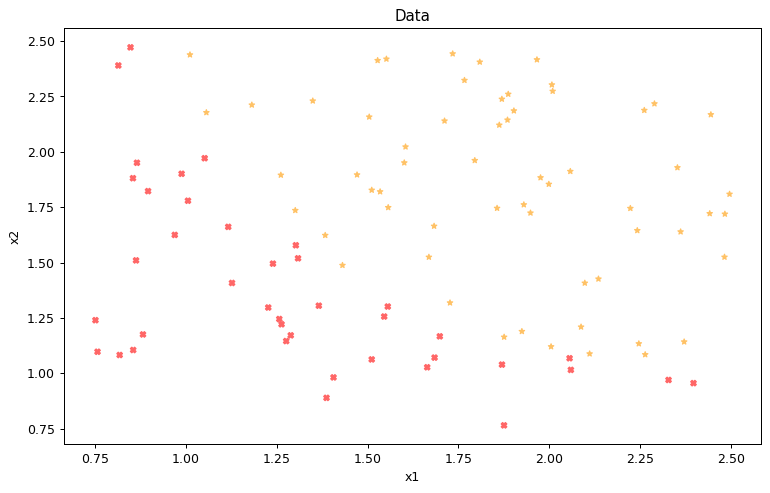

In [38]:
usu.drawSoftmax(data,ref)


In [39]:
def softmax(u):
    """
    vstupem muze byt skalar, vektor, nebo matice 
    """
    #################################################################
    # ZDE DOPLNIT

    # Numerical stability: subtract max value to prevent overflow
    u_shifted = u - np.max(u, axis=0, keepdims=True)
    exp_u = np.exp(u_shifted)
    y = exp_u / np.sum(exp_u, axis=0, keepdims=True)
    
    #################################################################
    return y

usu.checkSoftmax(softmax)

True

In [40]:
def computeThetaGD(x, y, alpha=0.01, iterations=1000, plot_loss=False):
    # pro kazdou iteraci vypoctete loss a zapiste ho na odpovidajici index v promenne
    loss = np.zeros(iterations)

    #################################################################
    # ZDE DOPLNIT

    #flatten y if needed (handle both (N,) and (N,1) shapes)
    y = y.flatten()
    
    # Get number of samples and features
    n_samples = x.shape[0]
    n_features = x.shape[1]
    n_classes = np.max(y) + 1
    
    #add bias term to x
    _x = np.c_[np.ones(n_samples), x]
    
    #initialize theta with small random values
    theta = np.random.randn(n_features + 1, n_classes) * 0.01
    
    #one-hot encode the target classes - important for softmax - y must be flattened
    _y = np.zeros((n_samples, n_classes))
    _y[np.arange(n_samples), y] = 1
    
    # Gradient descent iterations
    for i in range(iterations):
        # Compute predictions using softmax
        u = _x @ theta  # Linear combination
        prediction = softmax(u.T).T  # Apply softmax row-wise
        
        # Compute gradient
        gradient = _x.T @ (prediction - _y)
        
        # Update theta
        theta = theta - alpha * gradient
        
        # Compute loss (cross-entropy)
        loss[i] = -np.sum(_y * np.log(prediction + 1e-15)) / n_samples
    
    #################################################################

    if plot_loss:
        show_loss(np.arange(iterations), loss)

    return theta


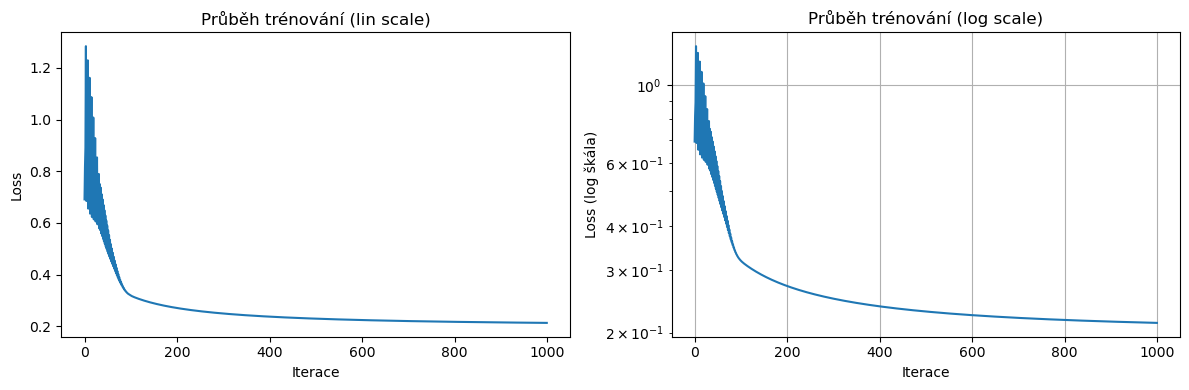

array([[ 9.10835232, -9.10928507],
       [-3.0229346 ,  3.00587261],
       [-2.91138678,  2.89707629]])

In [41]:
theta = computeThetaGD(data, ref, plot_loss=True)
theta

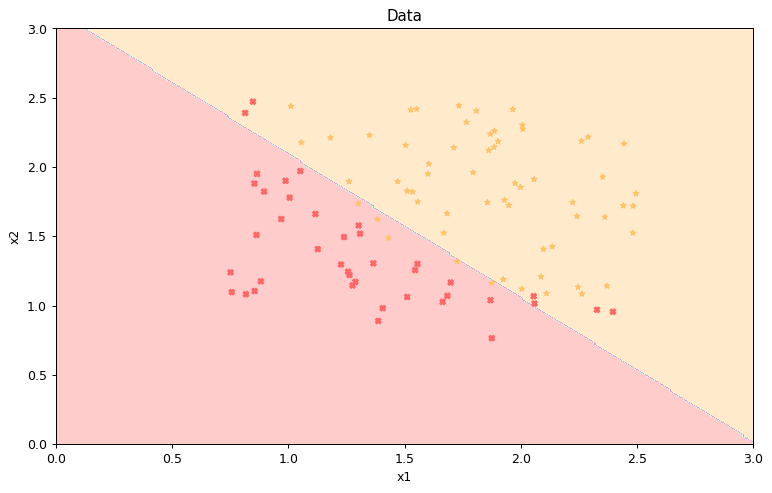

In [42]:
usu.drawSoftmax(data, ref, theta, softmax)


In [43]:
def predict(x, theta):
    #################################################################
    # ZDE DOPLNIT
    #add bias term to x
    _x = np.c_[np.ones(x.shape[0]), x]
    
    #compute linear combination
    u = _x @ theta
    
    #apply softmax and get predicted classes
    #softmax (with axis=0) normalizes columns but expects samples (u matrix has samples rows wise), but we need to normalize rows (sample)
    #so we transpose before/after: each column becomes a sample, softmax normalizes it, then transpose back
    prediction = softmax(u.T).T
    classes = np.argmax(prediction, axis=1)
    #################################################################
    return classes


In [44]:
x_pred = np.array([[1, 1],[ 2, 2]])
predict(x_pred,theta)


array([0, 1])

### Klasifikace pro více tříd:
#### 3 třídy:


In [45]:
npzfile = np.load('data/data_07_3cl_ez.npz') 

data = npzfile['data']
ref = npzfile['ref']

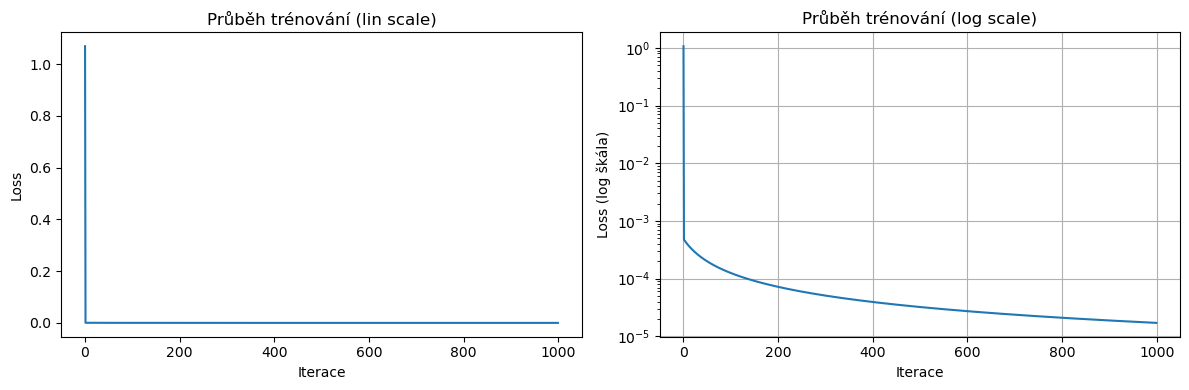

array([[ 0.52012594, -0.54224625,  0.01443686],
       [ 2.65024143,  5.8007352 , -8.42600536],
       [-7.40962574,  4.62736423,  2.78175572]])

In [46]:
theta = computeThetaGD(data, ref, plot_loss=True)
theta

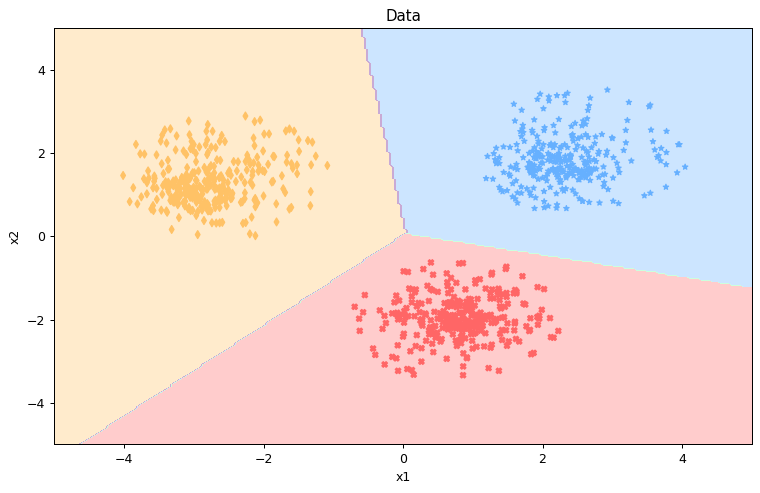

In [47]:
usu.drawSoftmax(data, ref, theta, softmax)


In [48]:
x_pred = np.array([[-3, 1],[ 0, -2],[ 3, 2]])
predict(x_pred,theta)


array([2, 0, 1])

#### 4 třídy:

In [49]:
npzfile = np.load('data/data_07_4cl.npz')

data = npzfile['data']
ref = npzfile['ref']


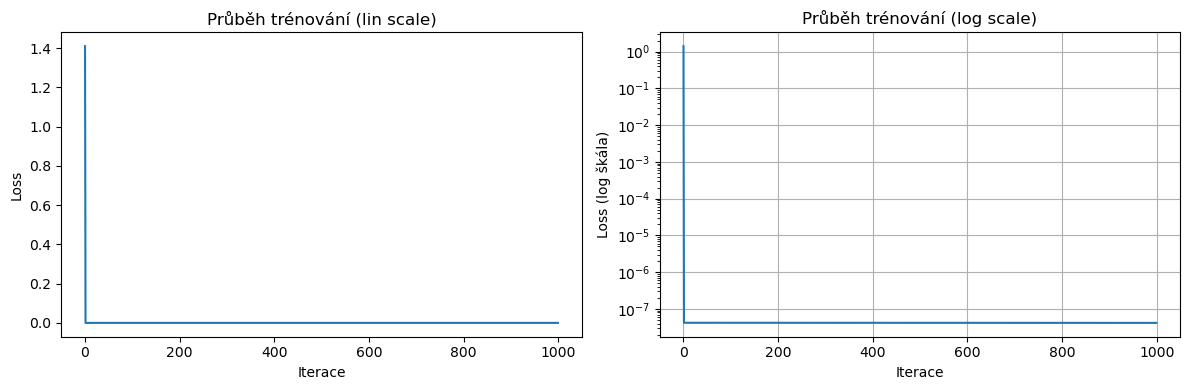

array([[ 1.39033415e-02, -2.81472677e-02, -1.89892614e-03,
        -6.87676041e-05],
       [ 8.43397164e+00,  6.72084371e+00, -7.25217807e+00,
        -7.88834547e+00],
       [-6.88216209e+00,  7.04903556e+00, -7.47579937e+00,
         7.32711489e+00]])

In [50]:
theta = computeThetaGD(data, ref, plot_loss=True)
theta

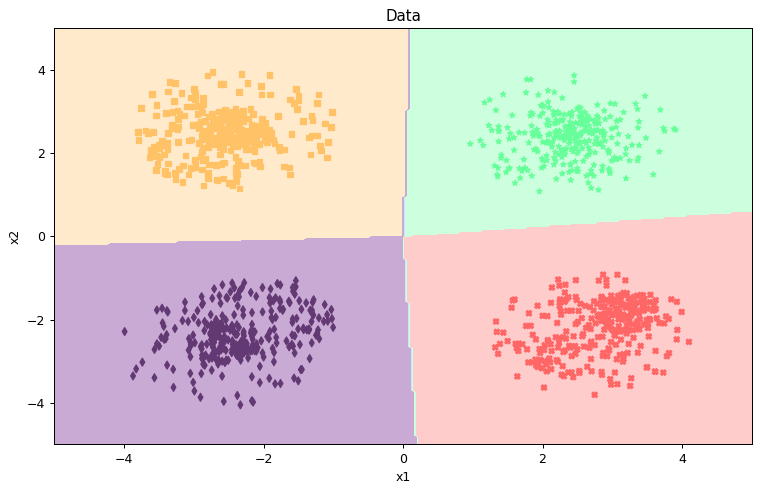

In [51]:
usu.drawSoftmax(data, ref, theta, softmax)


In [52]:
x_pred = np.array([[-3, -1],[ -3, 2],[ 3, -1],[ 3, 2]])
predict(x_pred,theta)


array([2, 3, 0, 1])

#### 5 tříd:

In [53]:
npzfile = np.load('data/data_07_5cl.npz')

data = npzfile['data']
ref = npzfile['ref']


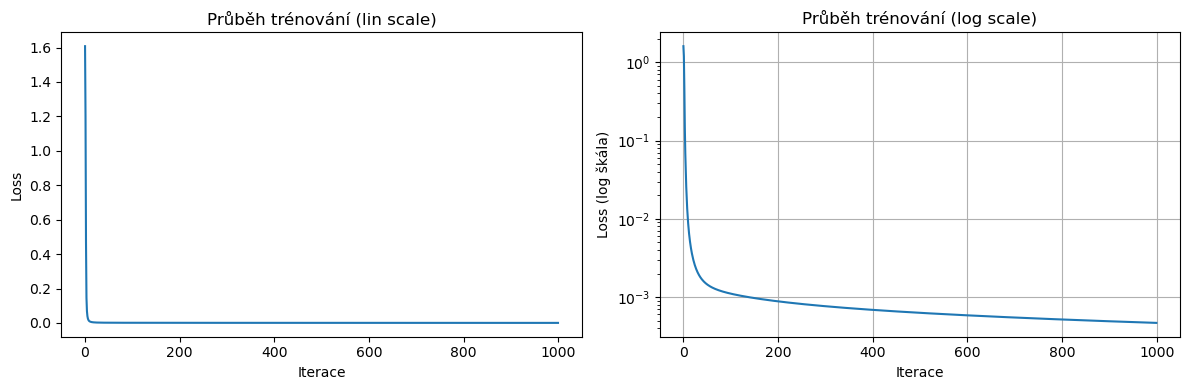

array([[-2.44986427, -3.16623664, -3.16219078, -2.59725312, 11.37411545],
       [ 7.16452913,  6.4400811 , -7.02539553, -6.31235573, -0.25107091],
       [-5.6788793 ,  6.28162462, -6.8799715 ,  6.37625347, -0.07464261]])

In [54]:
theta = computeThetaGD(data, ref, plot_loss=True)
theta

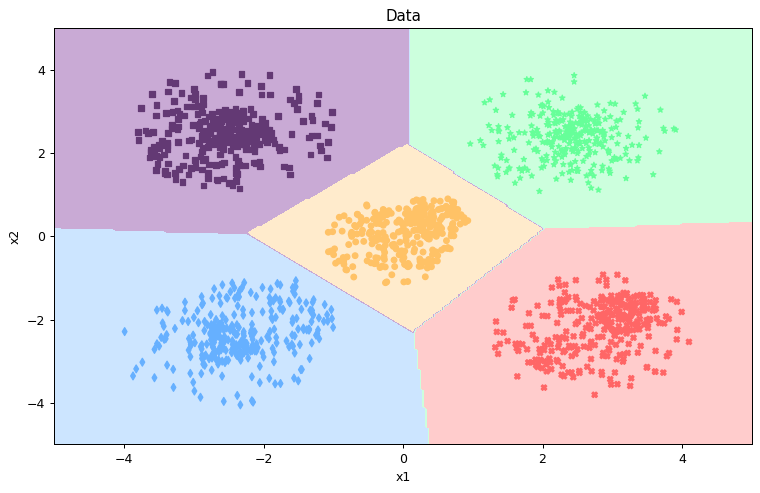

In [55]:
usu.drawSoftmax(data, ref, theta, softmax)


In [56]:
x_pred = np.array([[-3, -1],[ -3, 2],[ 3, -1],[ 3, 2],[0, 0]])
predict(x_pred,theta)


array([2, 3, 0, 1, 4])

# BONUS: Rozpoznávání číslovek (MNIST database) a mini-batch gradient descent

### **Dosáhněte accuracy (vypočtené na konci) alespoň 91 %.**

In [66]:
npzfile = np.load('data/data_07_mnist_train.npz') 

data = npzfile['data']
ref = npzfile['ref']
data.shape, ref.shape

((60000, 784), (60000,))

Prohlédněte si prvních 20 trénovacích vzorků:

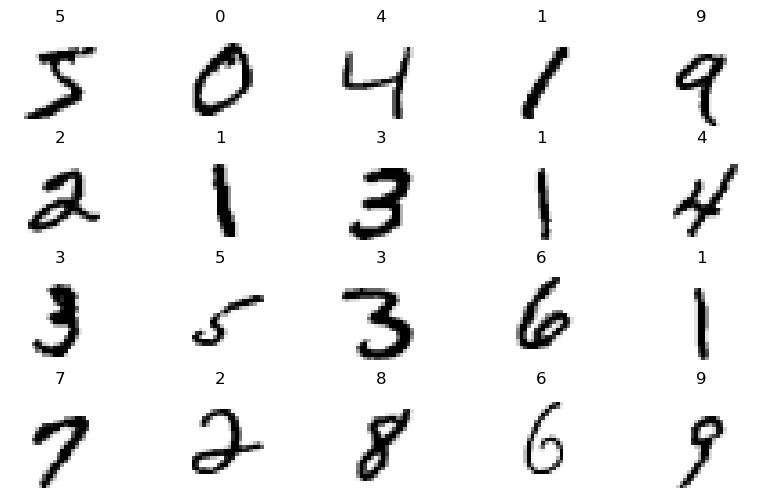

In [58]:
plt.figure(figsize=(10, 6))
for i in range(20):
    # Prevedeni linearizovych dat zpet na 2D matici.
    img = np.reshape(data[i], (28, 28))
    plt.subplot(4, 5, i+1)
    plt.imshow(img, "gray_r")
    plt.title(ref[i])
    plt.axis("off") 
plt.show()

Naimplementuje trénování modelu pomocí mini-batch gradient descent:

Mini-batch gradient descent vzhledem k množství dat zefektivní trénování (model se natrénuje rychleji a lépe zobecňuje).

Vyjděte z předchozí implementace `computeThetaGD` a upravte ji.

Počet iterací (u GD ekvivalentní průchodu všemi testovacími daty) bude nahrazen počtem tzv. epoch.

Jedna epocha probíhá následovně:
- Na začátku se náhodně zamíchají testovací data.
- Všechna testovací data se projdou po mini-batchích, jejichž délka je vždy rovna zadané `batch_size`. Na základě každého mini-batche se aktualizují váhy (u `computeThetaGD` se aktualizovaly váhy na základě všech dat). Pokud by na konci epochy zbyly vzorky, jejichž počet už je menší než `batch_size`, tak se přeskočí.
- Na konci epochy se spočítá loss na základě všech dat pro vizualizaci.

TIP: Vhodně normalizujte úpravu vah, aby její výsledná velikost nezávisela na `batch_size` a parametry `alpha` a `batch_size` jste mohli ladit nezávisle na sobě.

In [73]:
def computeThetaSGD(x, y, *, alpha, epochs, batch_size, plot_loss=False):
    # zafixovani nahody pri trenovani
    np.random.seed(0)

    # na konci kazde epochy vypoctete loss (ze vsech trenovacich vzorku) a zapiste ho na odpovidajici index v promenne
    loss = np.zeros(epochs)

    #################################################################
    # ZDE DOPLNIT
    # Normalize input data to [0, 1]
    x = x / 255.0

    # Flatten y if needed (handle both (N,) and (N,1) shapes)
    y = y.flatten()
    
    # Get number of samples, features, and classes
    n_samples = x.shape[0]
    n_features = x.shape[1]
    n_classes = np.max(y) + 1
    
    # Add bias term to x
    X = np.c_[np.ones(n_samples), x]
    
    # Initialize theta with small random values
    theta = np.random.randn(n_features + 1, n_classes) * 0.01
    
    # One-hot encode the target classes
    Y = np.zeros((n_samples, n_classes))
    Y[np.arange(n_samples), y] = 1
    
    # Mini-batch gradient descent
    for epoch in range(epochs):
        # Shuffle data at the beginning of each epoch
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        Y_shuffled = Y[indices]
        
        # Process mini-batches
        for i in range(0, n_samples - batch_size + 1, batch_size):
            # Optional: Decay learning rate over epochs
            # current_alpha = alpha / (1 + 0.01 * epoch)

            # Get mini-batch
            X_batch = X_shuffled[i:i+batch_size]
            Y_batch = Y_shuffled[i:i+batch_size]
            
            # Compute predictions using softmax
            u = X_batch @ theta
            Y_pred = softmax(u.T).T
            
            # Compute gradient and normalize by batch_size
            gradient = X_batch.T @ (Y_pred - Y_batch) / batch_size
            
            # Update theta
            theta = theta - alpha * gradient
        
        # Compute loss on all training data at the end of epoch
        u_all = X @ theta
        Y_pred_all = softmax(u_all.T).T
        loss[epoch] = -np.sum(Y * np.log(Y_pred_all + 1e-15)) / n_samples
    
    #################################################################

    if plot_loss:
        show_loss(np.arange(epochs), loss, epoch=True)

    return theta


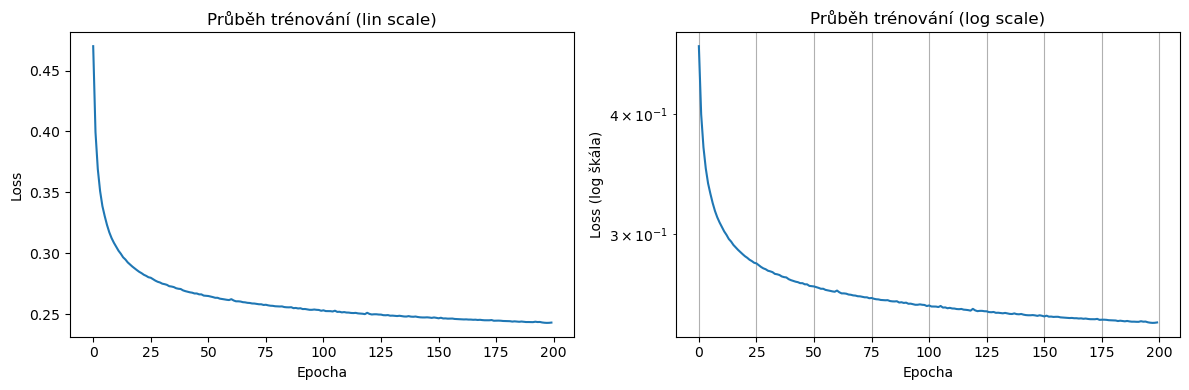

array([[-9.69440907e-01,  8.54123306e-01,  2.12886289e-01, ...,
         1.30136676e+00, -2.24827101e+00, -4.79996494e-01],
       [ 1.44043571e-03,  1.45427351e-02,  7.61037725e-03, ...,
        -2.05158264e-03,  3.13067702e-03, -8.54095739e-03],
       [-2.55298982e-02,  6.53618595e-03,  8.64436199e-03, ...,
        -1.87183850e-03,  1.53277921e-02,  1.46935877e-02],
       ...,
       [-1.49282498e-02, -2.38229840e-03, -1.27114134e-02, ...,
        -3.56723327e-03,  1.26309448e-02,  9.82297675e-04],
       [-5.78702967e-03, -1.29565356e-02,  8.18896155e-03, ...,
         2.19676213e-04, -2.26237591e-03,  8.00552643e-03],
       [ 2.58334164e-03,  1.34167906e-04, -9.56635808e-03, ...,
         1.67141696e-02,  1.42307301e-02, -5.66348461e-03]])

In [79]:
 # ZDE DOPLNIT hodnoty hyperparametrů (dostatečný model lze natrénovat během 5-10 sekund)
theta = computeThetaSGD(data, ref, batch_size=256, epochs=200, alpha=0.1, plot_loss=True)
#################################################################

theta

Prohlédněte si natrénované váhy (s výjimkou biasu):

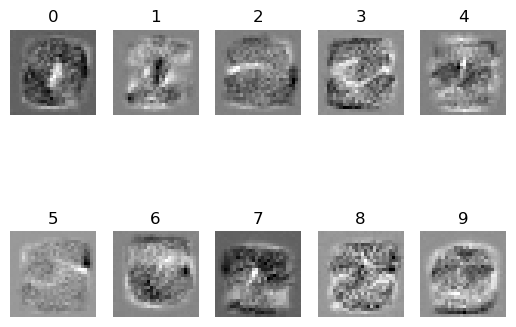

In [80]:
for i in range(theta.shape[1]):
    # Prvni vaha je bias, zbytek odpovida bodum v obrazu, takze je preskupime na 2D obraz.
    img = np.reshape(theta.T[i][1:], (28, 28))
    plt.subplot(2, 5, i+1)
    plt.imshow(img, "gray_r")
    plt.title(str(i))
    plt.axis("off") 
plt.show()

In [81]:
npzfile = np.load('data/data_07_mnist_test.npz') 

test_data = npzfile['data']
test_ref = npzfile['ref']

Otestujte prvních 20 testovacích vzorků:

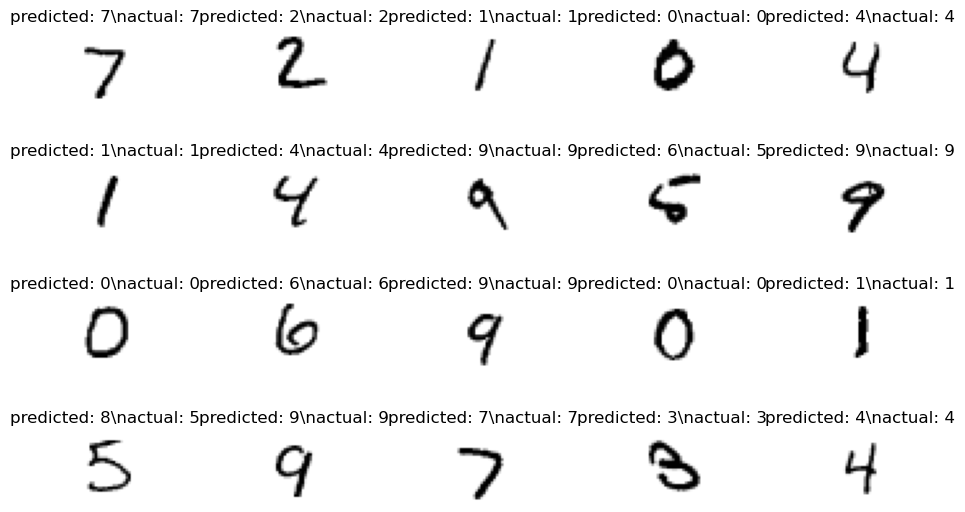

In [82]:
n = 20
x = test_data[:n, :]
y = test_ref[:n]

#################################################################
# ZDE DOPLNIT - Zjistete predikovane tridy pro `x`

y_pred = predict(x, theta)

#################################################################

plt.figure(figsize=(10, 6))
for i in range(n):
    # Prevedeni linearizovych dat zpet na 2D matici.
    img = np.reshape(x[i, :], (28, 28))
    plt.subplot(4, 5, i+1)
    plt.tight_layout(pad=3.0)
    plt.imshow(img, "gray_r")
    plt.title(f"predicted: {y_pred[i]}\\nactual: {y[i]}")
    plt.axis("off")
plt.show()

Accuracy – přesnost natrénovaného modelu:

In [83]:
#################################################################
# ZDE DOPLNIT - Zjistete predikovane tridy pro vsechna testovaci data a procento spravne predikovanych dat (accuracy).

test_pred = predict(test_data, theta)
accuracy = np.mean(test_pred == test_ref)

#################################################################

print(f"Accuracy: {accuracy * 100}%")

Accuracy: 87.06%


Navíc: všimněte si, jak se mění grafy vah, když zvyšujete/snižujete batch size.